In [2]:
!tar -xvf GOSIF_2023361.tif.gz

tar: This does not look like a tar archive
tar: Skipping to next header
tar: Exiting with failure status due to previous errors


In [4]:
import gzip
import shutil
import os

# Define file paths
compressed_file_path = "GOSIF_2023361.tif.gz"
extracted_file_path = "GOSIF_2023361.tif"

# Extract the .gz file
with gzip.open(compressed_file_path, 'rb') as f_in:
    with open(extracted_file_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Check if the file was successfully extracted
os.path.exists(extracted_file_path)

True

In [5]:
import xarray as xr

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import tifffile

# Read the TIFF image data
with tifffile.TiffFile(extracted_file_path) as tif:
    image_data = tif.pages[0].asarray()

# Convert the TIFF image data to a NetCDF file
netcdf_file_path = "GOSIF_2023361.nc"

# Create an xarray dataset
ds = xr.Dataset(
    {
        "GOSIF_Data": (("y", "x"), image_data)  # Store the TIFF data as a variable
    },
    coords={
        "y": np.arange(image_data.shape[0]),  # Define y-coordinates
        "x": np.arange(image_data.shape[1]),  # Define x-coordinates
    },
)

# Save to NetCDF format
ds.to_netcdf(netcdf_file_path)

# Return the file path for download
netcdf_file_path

'GOSIF_2023361.nc'

In [9]:
# Extract georeferencing information from TIFF (if available)
with tifffile.TiffFile(extracted_file_path) as tif:
    page = tif.pages[0]
    tags = page.tags

    # Attempt to extract GeoTIFF metadata
    if 33550 in tags and 33922 in tags and 34737 in tags:  # GeoTIFF standard tags
        model_pixel_scale = tags[33550].value  # Pixel scale (size of each pixel)
        model_tie_point = tags[33922].value  # Tie point (origin of coordinates)

        # Compute lat/lon coordinates
        x_res = model_pixel_scale[0]
        y_res = model_pixel_scale[1]
        lon_origin = model_tie_point[3]
        lat_origin = model_tie_point[4]

        # Generate lat/lon arrays
        lons = np.linspace(lon_origin, lon_origin + (image_data.shape[1] * x_res), image_data.shape[1])
        lats = np.linspace(lat_origin, lat_origin - (image_data.shape[0] * y_res), image_data.shape[0])

        has_georef = True
    else:
        has_georef = False

# If georeferencing is available, use it; otherwise, fallback to index-based coordinates
if has_georef:
    ds = xr.Dataset(
        {
            "GOSIF_Data": (("y", "x"), image_data)
        },
        coords={
            "lat": ("y", lats),
            "lon": ("x", lons),
        },
    )
else:
    ds = xr.Dataset(
        {
            "GOSIF_Data": (("y", "x"), image_data)
        },
        coords={
            "y": np.arange(image_data.shape[0]),
            "x": np.arange(image_data.shape[1]),
        },
    )

# Save to NetCDF format with proper lat/lon
netcdf_file_path = "GOSIF_2023361_with_latlon.nc"
ds.to_netcdf(netcdf_file_path)

# Return the file path for download
netcdf_file_path


'GOSIF_2023361_with_latlon.nc'

In [10]:
ds = xr.open_dataset('GOSIF_2023361_with_latlon.nc')
ds

<xarray.Dataset> Size: 52MB
Dimensions:     (x: 7200, y: 3600)
Coordinates:
  * x           (x) int32 29kB 0 1 2 3 4 5 6 ... 7194 7195 7196 7197 7198 7199
  * y           (y) int32 14kB 0 1 2 3 4 5 6 ... 3594 3595 3596 3597 3598 3599
Data variables:
    GOSIF_Data  (y, x) int16 52MB ...

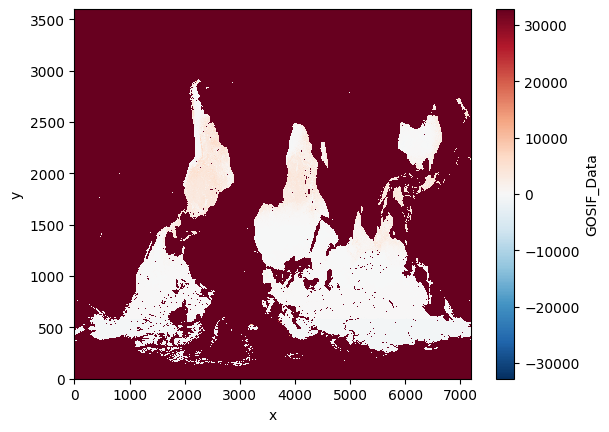

In [12]:
ds.GOSIF_Data.plot()

In [21]:
# Assuming `ds` is your existing dataset
# x_dim = ds.dims["x"]
# y_dim = ds.dims["y"]

x_dim = 7200
y_dim = 3600

# Generate longitude and latitude values
longitudes = np.linspace(0, 360, x_dim, endpoint=False)  # Longitudes from 0 to 360
latitudes = np.linspace(-90, 90, y_dim)  # Latitudes from -90 to 90


# # Generate longitude and latitude values
# longitudes = np.linspace(0, 360, x_dim, endpoint=False)  # Longitudes from 0 to 360
# latitudes = np.linspace(-90, 90, y_dim)  # Latitudes from -90 to 90

# Add longitude and latitude as coordinates
ds = ds.assign_coords(
    longitude=("x", longitudes),
    latitude=("y", latitudes)
)


In [22]:
data = ds.GOSIF_Data.values.astype(float)
data[data==32767] = np.nan
ds['sif'] = (('y', 'x'), np.flipud(data))
ds

<xarray.Dataset> Size: 259MB
Dimensions:     (x: 7200, y: 3600)
Coordinates:
  * x           (x) int32 29kB 0 1 2 3 4 5 6 ... 7194 7195 7196 7197 7198 7199
  * y           (y) int32 14kB 0 1 2 3 4 5 6 ... 3594 3595 3596 3597 3598 3599
    longitude   (x) float64 58kB 0.0 0.05 0.1 0.15 ... 359.8 359.9 359.9 360.0
    latitude    (y) float64 29kB -90.0 -89.95 -89.9 -89.85 ... 89.9 89.95 90.0
Data variables:
    GOSIF_Data  (y, x) int16 52MB 32767 32767 32767 32767 ... 32767 32767 32767
    sif         (y, x) float64 207MB nan nan nan nan nan ... nan nan nan nan nan

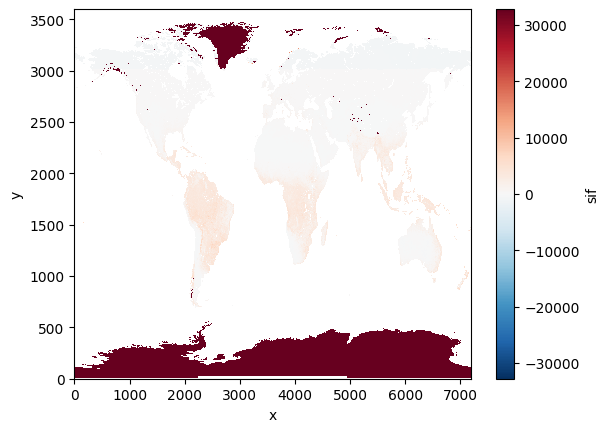

In [23]:
ds.sif.plot()

Text(0, 0.5, 'Latitude')

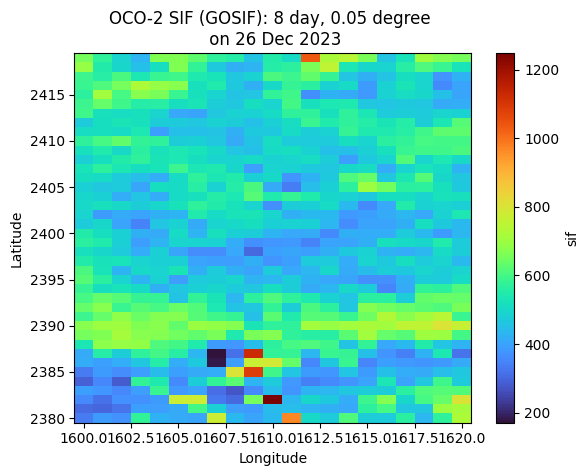

In [38]:
ds.sif.sel(y=ds.y[(ds.latitude >= 29) & (ds.latitude <= 31)]).sel(x=ds.x[(ds.longitude >= 180-100) & (ds.longitude <= 180-99)]) \
.plot(cmap='turbo')
plt.title('OCO-2 SIF (GOSIF): 8 day, 0.05 degree \n on 26 Dec 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [39]:
ds_transformed = ds.swap_dims({'x': 'longitude', 'y': 'latitude'}).drop_vars(['x', 'y'])
ds_transformed

<xarray.Dataset> Size: 259MB
Dimensions:     (latitude: 3600, longitude: 7200)
Coordinates:
  * longitude   (longitude) float64 58kB 0.0 0.05 0.1 0.15 ... 359.9 359.9 360.0
  * latitude    (latitude) float64 29kB -90.0 -89.95 -89.9 ... 89.9 89.95 90.0
Data variables:
    GOSIF_Data  (latitude, longitude) int16 52MB 32767 32767 ... 32767 32767
    sif         (latitude, longitude) float64 207MB nan nan nan ... nan nan nan

Text(0, 0.5, 'Latitude')

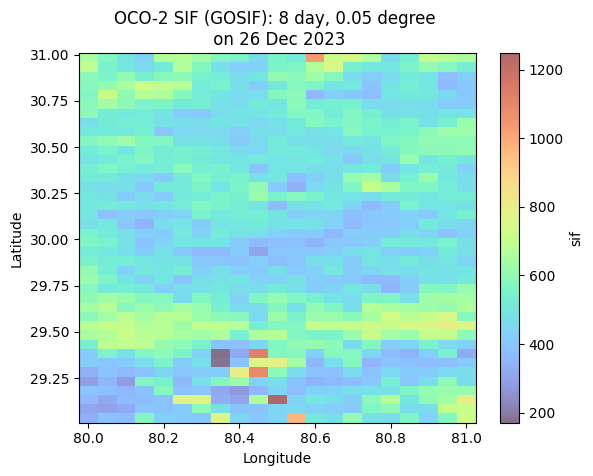

In [41]:
ds_transformed.sif.sel(latitude=slice(29,31)).sel(longitude = slice(180-100, 180-99)).plot(cmap='turbo', alpha=0.6)
plt.title('OCO-2 SIF (GOSIF): 8 day, 0.05 degree \n on 26 Dec 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [42]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 63.6 MB/s eta 0:00:00


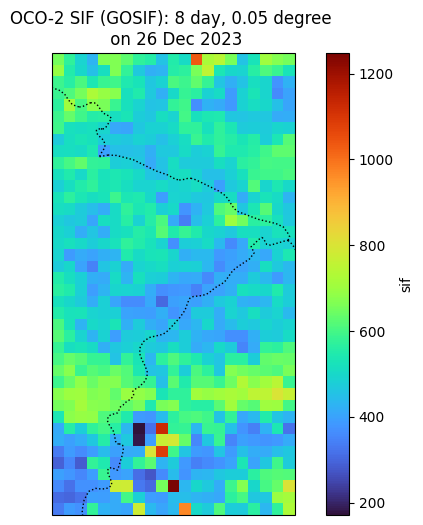

In [47]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create the figure and axis with cartopy projection
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data with transparency
ds_transformed.sif.sel(latitude=slice(29,31), longitude=slice(180-100, 180-99)).plot(
    cmap='turbo', ax=ax
)


ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1, edgecolor='black')  # Country borders


# Titles and Labels
plt.title('OCO-2 SIF (GOSIF): 8 day, 0.05 degree \n on 26 Dec 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the final plot
plt.show()

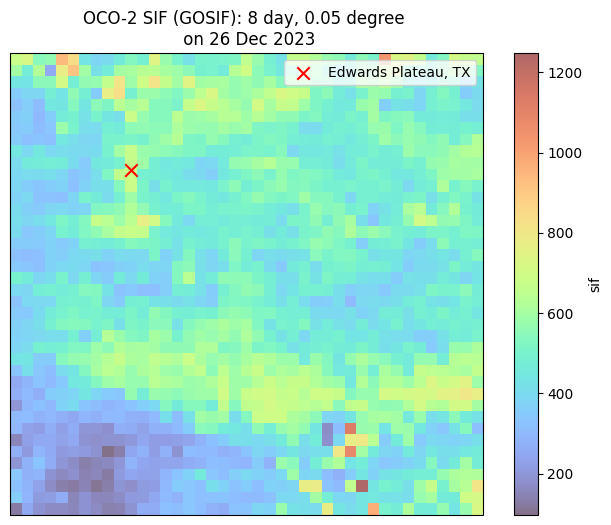

In [57]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create the figure and axis with cartopy projection
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data with transparency
ds_transformed.sif.sel(latitude=slice(29,31), longitude=slice(180-101, 180-99)).plot(
    cmap='turbo', alpha=0.6, ax=ax
)
edwards_plateau_coords = (180-100.5, 30.5)  # Approximate location
ax.scatter(*edwards_plateau_coords, color='red', marker='x', s=80, label="Edwards Plateau, TX")
plt.title('OCO-2 SIF (GOSIF): 8 day, 0.05 degree \n on 26 Dec 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


ax.legend()


plt.show()

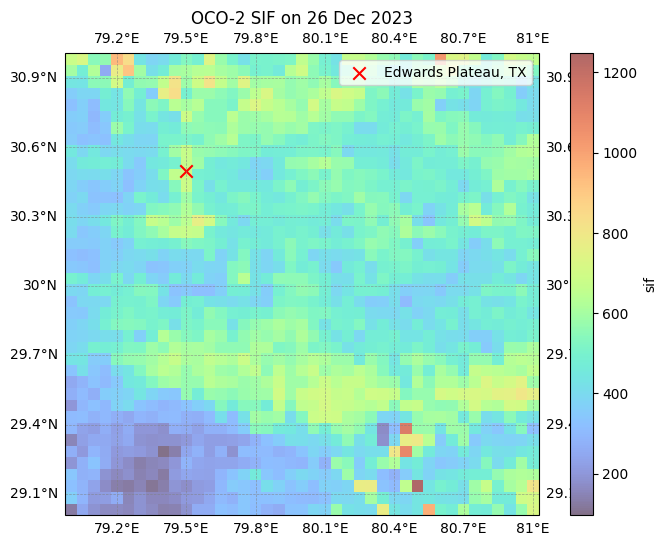

In [60]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Create the figure and axis with cartopy projection
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data with transparency
ds_transformed.sif.sel(latitude=slice(29,31), longitude=slice(180-101, 180-99)).plot(
    cmap='turbo', alpha=0.6, ax=ax
)

# Mark Edwards Plateau
edwards_plateau_coords = (180-100.5, 30.5)  # Approximate location
ax.scatter(*edwards_plateau_coords, color='red', marker='x', s=80, label="Edwards Plateau, TX")

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
gl.xlabels_top = False  # Remove top longitude labels
gl.ylabels_right = False  # Remove right latitude labels
gl.xformatter = LONGITUDE_FORMATTER  # Format longitude labels
gl.yformatter = LATITUDE_FORMATTER  # Format latitude labels
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Titles and Labels
plt.title('OCO-2 SIF on 26 Dec 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add legend
ax.legend()

# Show the final plot
plt.show()

<ipython-input-79-f16576f4e71f>:47: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/usr/local/lib/python3.11/dist-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/usr/local/lib/python3.11/dist-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/usr/local/lib/python3.11/dist-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/usr/local/lib/python3.11/dist-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data

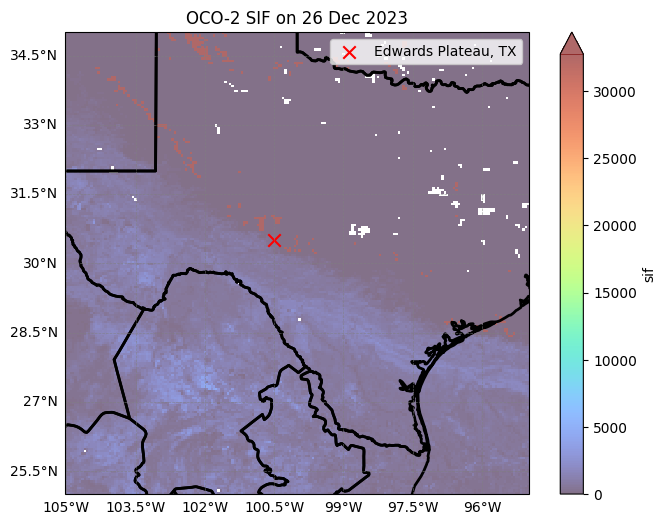

In [79]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

# Create the figure and axis with cartopy projection
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data with transparency
ds_transformed.sif.sel(latitude=slice(25,35), longitude=slice(360-105, 360-95)).plot(
    cmap='turbo', alpha=0.6, ax=ax, vmin=0, extend='max'
)

# Mark Edwards Plateau
edwards_plateau_coords = (360-100.5, 30.5)  # Approximate location
ax.scatter(*edwards_plateau_coords, color='red', marker='x', s=80, label="Edwards Plateau, TX")
# ✅ Fix: Load State Boundaries from Natural Earth Shapefile
# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1, edgecolor="black", label="Country Borders")

# ✅ Add ALL state boundaries (Including Texas)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.8, linestyle="-", label="State Boundaries")

# ✅ Manually highlight Texas state boundary (Thicker Line)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=2, linestyle="-", label="Texas Border")

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)

# Corrected attributes for removing top and right labels
gl.top_labels = False  # Remove top longitude labels
gl.right_labels = False  # Remove right latitude labels

# Format longitude and latitude labels
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Titles and Labels
plt.title('OCO-2 SIF on 26 Dec 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add legend
ax.legend()

# Show the final plot
plt.savefig('oco2.png', dpi=500)